# Introduction


word embeddings are dense vectors that represent words and they are what we use as input to our language models. These embeddings are trained separately than our models on lots of text..that could be text from Wikipedia, from other places on the internet or specialized content, like SPDs.


When we train our models we can adjust these embeddings, but it's usually better to freeze them since allowing them to change creates too many flexible parameters and leads us to over-fit easily.


If we normalize our text before hand we can control what our word embeddings are eg we could convert words like 
`OOP` to `out of pocket` or whatever we wish, it could be `outofpocket`, as long as we stick to this convention. This tutorial we learn how to creat our own embeddings or word representations.


This notebook trains on wikipedia data but eventually we'll collect our own texts with the help of Dani et al. and see how certain terms change!

# Word Embedding Tutorial: Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.


* http://ruder.io/word-embeddings-1/

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

an interesting with improvements:
* Distributed Representations of Words and Phrases and their Compositionality
http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils
import mutils

In [2]:
!pwd


/Users/macleodm/code/word-embedding-hackathon/src


Load the raw twitter dataset.  


In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

text = ''
with open('./data/twitter.txt') as f:
    for line in f:
        text += ' ' + line.strip().rstrip("\n\r")

In [4]:
type(text), len(text)

(str, 335493831)

In [5]:
print(text[0:200])

 Streaming twitter niggas name is bigtreesh I'm fucking weakkkk , treeshy RT THE BOSS:  , RT KU vs WVA delivery of the game ball by TOPEKA On road Supv. Paul Anderson! Rock Chalk , RT Hillary - Out of


## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up n (was five) below is 20 or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [6]:
# NB that words have a natural (meaningful) order as the occur in language and have context..that we'll use later!
words = mutils.preprocess(text, 20)

In [7]:
# NB notice that these are just strings..so we can preprocess our text to any specification we wish!
print(words[:100])

['Streaming', 'twitter', 'niggas', 'name', 'is', "I'm", 'fucking', '<COMMA>', 'RT', 'THE', 'BOSS', '<COLON>', '<COMMA>', 'RT', 'KU', 'vs', 'delivery', 'of', 'the', 'game', 'ball', 'by', 'On', 'road', '<PERIOD>', 'Paul', 'Anderson', '<EXCLAMATION_MARK>', 'Rock', '<COMMA>', 'RT', 'Hillary', '-', 'Out', 'of', 'Touch', 'On', 'Our', 'Planet', '<SEMICOLON>', 'Life', 'in', 'a', 'Titanium', 'Bubble', '<COMMA>', '…', 'RT', 'D3', 'State', 'Tournament', 'Wrestling', 'Update', '<COLON>', 'Brian', 'Garry', '<LEFT_PAREN>', '120', '<RIGHT_PAREN>', '&amp', '<SEMICOLON>', 'Spencer', '<LEFT_PAREN>', '195', '<RIGHT_PAREN>', 'have', 'both', 'advanced', 'to', 'the', 'State', 'RT', 'Day', '&amp', '<SEMICOLON>', 'night', 'Symmetra', '<EXCLAMATION_MARK>', 'Katsucon', 'is', 'going', 'really', 'well', 'so', 'far', '<PERIOD>', 'I’m', 'looking', 'forward', 'to', 'the', 'Overwatch', 'photoshoot', 'today', '<EXCLAMATION_MARK>', 'See', 'y…', 'is', 'a', 'lying']


In [8]:
print("Total words:  {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words:  70476899
Unique words: 68805


And here I'm creating dictionaries to covert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [11]:
# the dictionary my be ordered by frequency but the int_word order is same as text
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

### Special WC vocabulary terms we'd like to track

In [12]:
benefits_terms = ['insurance','maximum','claim','claims','policy','dime', 'D1']
non_benefit_terms = ['man', 'woman','cat','dog']
print('Benefit terms:')
for i in benefits_terms:
    print('term:', i, 'vocab integer:\t', vocab_to_int[i])
    
print()
print('Non Benefit terms:')
for i in non_benefit_terms:
    print('term:', i, 'vocab integer:\t', vocab_to_int[i])
    
benefits_terms_ints = [vocab_to_int[i] for i in benefits_terms]
non_benefits_terms_ints = [vocab_to_int[i] for i in non_benefit_terms]

Benefit terms:
term: insurance vocab integer:	 7631
term: maximum vocab integer:	 11646
term: claim vocab integer:	 2170
term: claims vocab integer:	 3048
term: policy vocab integer:	 2719
term: dime vocab integer:	 17261
term: D1 vocab integer:	 21863

Non Benefit terms:
term: man vocab integer:	 147
term: woman vocab integer:	 594
term: cat vocab integer:	 1059
term: dog vocab integer:	 758


In [13]:
my_terms = ['injury','compensation','worker','workers']
for i in my_terms:
    print('term:', i, 'vocab integer:\t', vocab_to_int[i])
my_terms_ints = [vocab_to_int[i] for i in my_terms]

term: injury vocab integer:	 6997
term: compensation vocab integer:	 14054
term: worker vocab integer:	 8007
term: workers vocab integer:	 4364


In [14]:
# note that a lot of terms we want are not in the dataset
print('Nice to have terms:')
nice_terms = ['PTD','TTD','DOI','DIME']
for i in nice_terms:
    print('term:',i, '\tin set:\t', i in set(words))

Nice to have terms:
term: PTD 	in set:	 False
term: TTD 	in set:	 False
term: DOI 	in set:	 False
term: DIME 	in set:	 False


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is that probability that a word is discarded. Assign the subsampled data to `train_words`.

In [15]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you chose a random number of words to from the window.

In [16]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [17]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as one-hot encoded vectors. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [18]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [19]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [20]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [21]:
random.sample(range(10),4)

[7, 8, 1, 9]

In [22]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    # add our special terms here
    valid_examples = np.append(valid_examples,benefits_terms_ints)
    valid_examples = np.append(valid_examples,non_benefits_terms_ints)
    valid_examples = np.append(valid_examples,my_terms_ints)
    
    valid_size = valid_size + len(benefits_terms_ints) + len(non_benefits_terms_ints) + len(my_terms_ints)
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [23]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: checkpoints: File exists


In [24]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/twitter.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.7592 0.2417 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.7977 0.2436 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.6874 0.2360 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.6736 0.2430 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.6177 0.2360 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.6148 0.2299 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.5094 0.2336 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.4329 0.2386 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.3520 0.2500 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.2381 0.2498 sec/batch
Nearest to <PERIOD>: apple, it, 😕, condolences, do/ask, UNITED, tainted, substitute”,
Nearest to it: High, Umm, <PERIOD>, indictments, sneak, pertinent, systems', miller,
Nearest to If: commissions, Conspiracy, aesthetics, Seducer, ksoogifs, Barry, stang, Hahahahahahaha,
Nearest to me: 'kilig', eva

Epoch 1/10 Iteration: 3100 Avg. Training loss: 4.5455 0.2448 sec/batch
Epoch 1/10 Iteration: 3200 Avg. Training loss: 4.5145 0.2402 sec/batch
Epoch 1/10 Iteration: 3300 Avg. Training loss: 4.5177 0.2425 sec/batch
Epoch 1/10 Iteration: 3400 Avg. Training loss: 4.4822 0.2363 sec/batch
Epoch 1/10 Iteration: 3500 Avg. Training loss: 4.4965 0.2409 sec/batch
Epoch 1/10 Iteration: 3600 Avg. Training loss: 4.4757 0.2458 sec/batch
Epoch 1/10 Iteration: 3700 Avg. Training loss: 4.4863 0.2399 sec/batch
Epoch 1/10 Iteration: 3800 Avg. Training loss: 4.4836 0.2336 sec/batch
Epoch 1/10 Iteration: 3900 Avg. Training loss: 4.4499 0.2410 sec/batch
Epoch 1/10 Iteration: 4000 Avg. Training loss: 4.5034 0.2377 sec/batch
Nearest to <PERIOD>: night”, PANTHER, tainted, unreal, Breast, inconsistent, Kee…, oatmeal,
Nearest to it: Butt, Umm, ️🔥, indictments, sneak, sooner, Chastain, Goblet,
Nearest to If: Conspiracy, aesthetics, ksoogifs, Shipyard, empathy, Seducer, Soohorang, commissions,
Nearest to me: hikes,

Epoch 1/10 Iteration: 6100 Avg. Training loss: 4.3328 0.2543 sec/batch
Epoch 1/10 Iteration: 6200 Avg. Training loss: 4.3622 0.2450 sec/batch
Epoch 1/10 Iteration: 6300 Avg. Training loss: 4.3639 0.2412 sec/batch
Epoch 1/10 Iteration: 6400 Avg. Training loss: 4.3633 0.2470 sec/batch
Epoch 1/10 Iteration: 6500 Avg. Training loss: 4.3591 0.2403 sec/batch
Epoch 1/10 Iteration: 6600 Avg. Training loss: 4.3153 0.2410 sec/batch
Epoch 1/10 Iteration: 6700 Avg. Training loss: 4.3429 0.2414 sec/batch
Epoch 1/10 Iteration: 6800 Avg. Training loss: 4.3100 0.2369 sec/batch
Epoch 1/10 Iteration: 6900 Avg. Training loss: 4.2934 0.2422 sec/batch
Epoch 1/10 Iteration: 7000 Avg. Training loss: 4.3006 0.2352 sec/batch
Nearest to <PERIOD>: Kee…, oatmeal, Breast, —NY, version, searchs, night”, Matt,
Nearest to it: Butt, ️🔥, sneak, Chastain, sooner, keto, stamina, Header,
Nearest to If: Conspiracy, ksoogifs, polo, Shipyard, Seducer, ARRESTED, commissions, exciting,
Nearest to me: hikes, 1960s, interferen…,

Epoch 1/10 Iteration: 9100 Avg. Training loss: 4.4584 0.2408 sec/batch
Epoch 1/10 Iteration: 9200 Avg. Training loss: 4.4840 0.2441 sec/batch
Epoch 1/10 Iteration: 9300 Avg. Training loss: 4.4472 0.2459 sec/batch
Epoch 1/10 Iteration: 9400 Avg. Training loss: 4.4677 0.2448 sec/batch
Epoch 1/10 Iteration: 9500 Avg. Training loss: 4.4089 0.2514 sec/batch
Epoch 1/10 Iteration: 9600 Avg. Training loss: 4.3878 0.2492 sec/batch
Epoch 1/10 Iteration: 9700 Avg. Training loss: 4.3593 0.2512 sec/batch
Epoch 1/10 Iteration: 9800 Avg. Training loss: 4.3550 0.2481 sec/batch
Epoch 1/10 Iteration: 9900 Avg. Training loss: 4.3562 0.2466 sec/batch
Epoch 1/10 Iteration: 10000 Avg. Training loss: 4.3570 0.2568 sec/batch
Nearest to <PERIOD>: version, it, I, Breast, Matt, what, by, the,
Nearest to it: Butt, the, <PERIOD>, and, sooner, ️🔥, AOTY, focus…,
Nearest to If: Conspiracy, kinda, when, ksoogifs, polo, Seducer, 🌟🌸🌸, Shipyard,
Nearest to me: hikes, homosexuals, gerrymandering, love, fucking…, <QUOTATIO

Epoch 1/10 Iteration: 12100 Avg. Training loss: 4.2819 0.2391 sec/batch
Epoch 1/10 Iteration: 12200 Avg. Training loss: 4.2963 0.2415 sec/batch
Epoch 1/10 Iteration: 12300 Avg. Training loss: 4.2667 0.2429 sec/batch
Epoch 1/10 Iteration: 12400 Avg. Training loss: 4.2662 0.2410 sec/batch
Epoch 1/10 Iteration: 12500 Avg. Training loss: 4.2651 0.2411 sec/batch
Epoch 1/10 Iteration: 12600 Avg. Training loss: 4.2659 0.2441 sec/batch
Epoch 1/10 Iteration: 12700 Avg. Training loss: 4.2956 0.2430 sec/batch
Epoch 1/10 Iteration: 12800 Avg. Training loss: 4.2812 0.2427 sec/batch
Epoch 1/10 Iteration: 12900 Avg. Training loss: 4.2515 0.2436 sec/batch
Epoch 1/10 Iteration: 13000 Avg. Training loss: 4.2926 0.2423 sec/batch
Nearest to <PERIOD>: I, 4, This, version, for, Marvel, NKJV, with,
Nearest to it: ️🔥, Butt, get, song, <PERIOD>, sends, vape, perimeters,
Nearest to If: Conspiracy, 🌟🌸🌸, ksoogifs, Russia-gov-supported, ryt, Shipyard, polo, shrug,
Nearest to me: hikes, love, RT, 😫😫😫, fucking, back

Epoch 1/10 Iteration: 15100 Avg. Training loss: 4.1875 0.2381 sec/batch
Epoch 1/10 Iteration: 15200 Avg. Training loss: 4.2629 0.2304 sec/batch
Epoch 1/10 Iteration: 15300 Avg. Training loss: 4.2226 0.2318 sec/batch
Epoch 1/10 Iteration: 15400 Avg. Training loss: 4.2104 0.2316 sec/batch
Epoch 1/10 Iteration: 15500 Avg. Training loss: 4.2165 0.2315 sec/batch
Epoch 1/10 Iteration: 15600 Avg. Training loss: 4.2235 0.2319 sec/batch
Epoch 1/10 Iteration: 15700 Avg. Training loss: 4.3404 0.2320 sec/batch
Epoch 1/10 Iteration: 15800 Avg. Training loss: 4.5409 0.2322 sec/batch
Epoch 1/10 Iteration: 15900 Avg. Training loss: 4.4842 0.2308 sec/batch
Epoch 1/10 Iteration: 16000 Avg. Training loss: 4.4604 0.2329 sec/batch
Nearest to <PERIOD>: for, the, <COMMA>, RT, what, You, is, it,
Nearest to it: <PERIOD>, focus…, ️🔥, get, passionately, Butt, else, tucking,
Nearest to If: Conspiracy, 🌟🌸🌸, aesthetics, never, ryt, ARRESTED, on*, pro-Trump,
Nearest to me: checked, fucking, boys, hikes, you, back, l

Epoch 2/10 Iteration: 18100 Avg. Training loss: 4.3731 0.2536 sec/batch
Epoch 2/10 Iteration: 18200 Avg. Training loss: 4.3263 0.2450 sec/batch
Epoch 2/10 Iteration: 18300 Avg. Training loss: 4.2920 0.2417 sec/batch
Epoch 2/10 Iteration: 18400 Avg. Training loss: 4.2783 0.2549 sec/batch
Epoch 2/10 Iteration: 18500 Avg. Training loss: 4.2611 0.2399 sec/batch
Epoch 2/10 Iteration: 18600 Avg. Training loss: 4.2421 0.2497 sec/batch
Epoch 2/10 Iteration: 18700 Avg. Training loss: 4.2278 0.2464 sec/batch
Epoch 2/10 Iteration: 18800 Avg. Training loss: 4.2450 0.2474 sec/batch
Epoch 2/10 Iteration: 18900 Avg. Training loss: 4.2237 0.2454 sec/batch
Epoch 2/10 Iteration: 19000 Avg. Training loss: 4.2101 0.2471 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, the, I, a, you, to, is,
Nearest to it: <PERIOD>, is, to, a, just, and, the, <QUOTATION_MARK>,
Nearest to If: when, never, just, to, 🌟🌸🌸, you, aesthetics, pro-Trump,
Nearest to me: RT, you, when, I, checked, love, <PERIOD>, my,
Nearest to from: th

Epoch 2/10 Iteration: 21100 Avg. Training loss: 4.1292 0.2513 sec/batch
Epoch 2/10 Iteration: 21200 Avg. Training loss: 4.1465 0.2557 sec/batch
Epoch 2/10 Iteration: 21300 Avg. Training loss: 4.1419 0.2461 sec/batch
Epoch 2/10 Iteration: 21400 Avg. Training loss: 4.1529 0.2464 sec/batch
Epoch 2/10 Iteration: 21500 Avg. Training loss: 4.1602 0.2487 sec/batch
Epoch 2/10 Iteration: 21600 Avg. Training loss: 4.1089 0.2444 sec/batch
Epoch 2/10 Iteration: 21700 Avg. Training loss: 4.1539 0.2561 sec/batch
Epoch 2/10 Iteration: 21800 Avg. Training loss: 4.1313 0.2448 sec/batch
Epoch 2/10 Iteration: 21900 Avg. Training loss: 4.1154 0.2457 sec/batch
Epoch 2/10 Iteration: 22000 Avg. Training loss: 4.1146 0.2451 sec/batch
Nearest to <PERIOD>: <COMMA>, RT, I, the, you, for, with, a,
Nearest to it: <PERIOD>, do, just, the, and, <QUOTATION_MARK>, is, so,
Nearest to If: you, when, just, to, 🌟🌸🌸, there, aesthetics, know,
Nearest to me: I, you, RT, love, when, checked, so, i,
Nearest to from: moth…, die

Epoch 2/10 Iteration: 24100 Avg. Training loss: 4.0964 0.2380 sec/batch
Epoch 2/10 Iteration: 24200 Avg. Training loss: 4.1024 0.2420 sec/batch
Epoch 2/10 Iteration: 24300 Avg. Training loss: 4.0826 0.2389 sec/batch
Epoch 2/10 Iteration: 24400 Avg. Training loss: 4.0854 0.2413 sec/batch
Epoch 2/10 Iteration: 24500 Avg. Training loss: 4.0735 0.2450 sec/batch
Epoch 2/10 Iteration: 24600 Avg. Training loss: 4.0973 0.2424 sec/batch
Epoch 2/10 Iteration: 24700 Avg. Training loss: 4.1020 0.2320 sec/batch
Epoch 2/10 Iteration: 24800 Avg. Training loss: 4.0639 0.2413 sec/batch
Epoch 2/10 Iteration: 24900 Avg. Training loss: 4.0765 0.2416 sec/batch
Epoch 2/10 Iteration: 25000 Avg. Training loss: 4.0502 0.2431 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, the, for, I, to, you, what,
Nearest to it: the, RT, to, is, <PERIOD>, do, and, <COMMA>,
Nearest to If: to, there, just, when, you, within, 🌟🌸🌸, RT,
Nearest to me: checked, you, I, //, love, people, so, if,
Nearest to from: moth…, RT, died, <COMMA

Epoch 2/10 Iteration: 27100 Avg. Training loss: 4.2330 0.2483 sec/batch
Epoch 2/10 Iteration: 27200 Avg. Training loss: 4.2217 0.2453 sec/batch
Epoch 2/10 Iteration: 27300 Avg. Training loss: 4.2060 0.2424 sec/batch
Epoch 2/10 Iteration: 27400 Avg. Training loss: 4.1874 0.2430 sec/batch
Epoch 2/10 Iteration: 27500 Avg. Training loss: 4.1731 0.2424 sec/batch
Epoch 2/10 Iteration: 27600 Avg. Training loss: 4.1530 0.2437 sec/batch
Epoch 2/10 Iteration: 27700 Avg. Training loss: 4.1668 0.2424 sec/batch
Epoch 2/10 Iteration: 27800 Avg. Training loss: 4.1632 0.2419 sec/batch
Epoch 2/10 Iteration: 27900 Avg. Training loss: 4.1642 0.2423 sec/batch
Epoch 2/10 Iteration: 28000 Avg. Training loss: 4.1618 0.2428 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, the, I, you, a, is, in,
Nearest to it: RT, <PERIOD>, <COMMA>, the, and, to, you, a,
Nearest to If: just, you, to, within, there, when, <PERIOD>, RT,
Nearest to me: you, RT, I, and, <COMMA>, <PERIOD>, the, a,
Nearest to from: RT, moth…, died, a, i

Epoch 2/10 Iteration: 30100 Avg. Training loss: 4.1419 0.2486 sec/batch
Epoch 2/10 Iteration: 30200 Avg. Training loss: 4.1220 0.2434 sec/batch
Epoch 2/10 Iteration: 30300 Avg. Training loss: 4.1196 0.2435 sec/batch
Epoch 2/10 Iteration: 30400 Avg. Training loss: 4.1087 0.2427 sec/batch
Epoch 2/10 Iteration: 30500 Avg. Training loss: 4.1259 0.2450 sec/batch
Epoch 2/10 Iteration: 30600 Avg. Training loss: 4.1579 0.2400 sec/batch
Epoch 2/10 Iteration: 30700 Avg. Training loss: 4.1356 0.2440 sec/batch
Epoch 2/10 Iteration: 30800 Avg. Training loss: 4.1485 0.2409 sec/batch
Epoch 2/10 Iteration: 30900 Avg. Training loss: 4.1416 0.2449 sec/batch
Epoch 2/10 Iteration: 31000 Avg. Training loss: 4.1373 0.2438 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, the, for, I, to, is, you,
Nearest to it: RT, else, to, <COMMA>, just, but, get, <PERIOD>,
Nearest to If: within, You, to, there, you, do, just, addicts,
Nearest to me: I, you, <COMMA>, RT, checked, when, my, //,
Nearest to from: moth…, died, RT, 

Epoch 2/10 Iteration: 33100 Avg. Training loss: 4.1390 0.2463 sec/batch
Epoch 2/10 Iteration: 33200 Avg. Training loss: 4.1348 0.2441 sec/batch
Epoch 2/10 Iteration: 33300 Avg. Training loss: 4.1007 0.2228 sec/batch
Epoch 2/10 Iteration: 33400 Avg. Training loss: 4.1141 0.2447 sec/batch
Epoch 2/10 Iteration: 33500 Avg. Training loss: 4.1113 0.2428 sec/batch
Epoch 2/10 Iteration: 33600 Avg. Training loss: 4.1446 0.2438 sec/batch
Epoch 2/10 Iteration: 33700 Avg. Training loss: 4.3898 0.2451 sec/batch
Epoch 2/10 Iteration: 33800 Avg. Training loss: 4.3298 0.2434 sec/batch
Epoch 2/10 Iteration: 33900 Avg. Training loss: 4.3182 0.2394 sec/batch
Epoch 2/10 Iteration: 34000 Avg. Training loss: 4.2951 0.2446 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, the, is, I, for, in, a,
Nearest to it: RT, <PERIOD>, <COMMA>, for, else, because, to, get,
Nearest to If: within, to, You, there, yet, ask, you, do,
Nearest to me: I, checked, you, my, RT, <COMMA>, when, //,
Nearest to from: RT, <COMMA>, of, is, 

Epoch 3/10 Iteration: 36100 Avg. Training loss: 4.2653 0.2462 sec/batch
Epoch 3/10 Iteration: 36200 Avg. Training loss: 4.2205 0.2477 sec/batch
Epoch 3/10 Iteration: 36300 Avg. Training loss: 4.1967 0.2586 sec/batch
Epoch 3/10 Iteration: 36400 Avg. Training loss: 4.1593 0.2497 sec/batch
Epoch 3/10 Iteration: 36500 Avg. Training loss: 4.1440 0.2546 sec/batch
Epoch 3/10 Iteration: 36600 Avg. Training loss: 4.1279 0.2489 sec/batch
Epoch 3/10 Iteration: 36700 Avg. Training loss: 4.1463 0.2422 sec/batch
Epoch 3/10 Iteration: 36800 Avg. Training loss: 4.1243 0.2445 sec/batch
Epoch 3/10 Iteration: 36900 Avg. Training loss: 4.1280 0.2577 sec/batch
Epoch 3/10 Iteration: 37000 Avg. Training loss: 4.1192 0.2499 sec/batch
Nearest to <PERIOD>: <COMMA>, RT, I, the, is, you, a, in,
Nearest to it: <COMMA>, RT, <PERIOD>, to, you, of, this, and,
Nearest to If: you, to, want, there, You, <COMMA>, do, that,
Nearest to me: I, you, RT, <COMMA>, <PERIOD>, when, my, love,
Nearest to from: RT, a, of, <COMMA>, 

Epoch 3/10 Iteration: 39100 Avg. Training loss: 4.0701 0.2280 sec/batch
Epoch 3/10 Iteration: 39200 Avg. Training loss: 4.0497 0.2220 sec/batch
Epoch 3/10 Iteration: 39300 Avg. Training loss: 4.0771 0.2226 sec/batch
Epoch 3/10 Iteration: 39400 Avg. Training loss: 4.0702 0.2234 sec/batch
Epoch 3/10 Iteration: 39500 Avg. Training loss: 4.0540 0.2263 sec/batch
Epoch 3/10 Iteration: 39600 Avg. Training loss: 4.0980 0.2263 sec/batch
Epoch 3/10 Iteration: 39700 Avg. Training loss: 4.0595 0.2270 sec/batch
Epoch 3/10 Iteration: 39800 Avg. Training loss: 4.0753 0.2279 sec/batch
Epoch 3/10 Iteration: 39900 Avg. Training loss: 4.0670 0.2297 sec/batch
Epoch 3/10 Iteration: 40000 Avg. Training loss: 4.0386 0.2320 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, I, the, in, is, a, you,
Nearest to it: RT, this, <PERIOD>, and, just, what, you, <COMMA>,
Nearest to If: to, you, You, do, want, there, RT, if,
Nearest to me: I, checked, RT, you, my, i, //, people,
Nearest to from: RT, moth…, My, a, is, <COMMA>,

Epoch 3/10 Iteration: 42100 Avg. Training loss: 4.0349 0.2410 sec/batch
Epoch 3/10 Iteration: 42200 Avg. Training loss: 4.0300 0.2331 sec/batch
Epoch 3/10 Iteration: 42300 Avg. Training loss: 4.0387 0.2522 sec/batch
Epoch 3/10 Iteration: 42400 Avg. Training loss: 4.0028 0.2449 sec/batch
Epoch 3/10 Iteration: 42500 Avg. Training loss: 4.0287 0.2331 sec/batch
Epoch 3/10 Iteration: 42600 Avg. Training loss: 4.0277 0.2330 sec/batch
Epoch 3/10 Iteration: 42700 Avg. Training loss: 3.9951 0.2486 sec/batch
Epoch 3/10 Iteration: 42800 Avg. Training loss: 4.0081 0.2338 sec/batch
Epoch 3/10 Iteration: 42900 Avg. Training loss: 4.0343 0.2309 sec/batch
Epoch 3/10 Iteration: 43000 Avg. Training loss: 4.0346 0.2348 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, the, I, to, for, you, in,
Nearest to it: RT, <COMMA>, the, to, is, for, you, this,
Nearest to If: you, You, to, want, do, <COMMA>, there, RT,
Nearest to me: checked, I, you, i, //, so, my, people,
Nearest to from: moth…, died, My, drug, prison, a

Epoch 3/10 Iteration: 45100 Avg. Training loss: 4.1722 0.2388 sec/batch
Epoch 3/10 Iteration: 45200 Avg. Training loss: 4.1348 0.2272 sec/batch
Epoch 3/10 Iteration: 45300 Avg. Training loss: 4.1056 0.2357 sec/batch
Epoch 3/10 Iteration: 45400 Avg. Training loss: 4.1033 0.2363 sec/batch
Epoch 3/10 Iteration: 45500 Avg. Training loss: 4.0888 0.2346 sec/batch
Epoch 3/10 Iteration: 45600 Avg. Training loss: 4.0813 0.2372 sec/batch
Epoch 3/10 Iteration: 45700 Avg. Training loss: 4.0850 0.2368 sec/batch
Epoch 3/10 Iteration: 45800 Avg. Training loss: 4.1005 0.2371 sec/batch
Epoch 3/10 Iteration: 45900 Avg. Training loss: 4.1056 0.2392 sec/batch
Epoch 3/10 Iteration: 46000 Avg. Training loss: 4.0721 0.2392 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, I, the, in, is, you, a,
Nearest to it: RT, <COMMA>, you, to, the, but, this, <PERIOD>,
Nearest to If: you, You, do, <PERIOD>, want, to, RT, be,
Nearest to me: you, I, RT, <COMMA>, my, checked, i, so,
Nearest to from: a, RT, moth…, died, My, drug,

Epoch 3/10 Iteration: 48100 Avg. Training loss: 4.0650 0.2387 sec/batch
Epoch 3/10 Iteration: 48200 Avg. Training loss: 4.0642 0.2341 sec/batch
Epoch 3/10 Iteration: 48300 Avg. Training loss: 4.0867 0.2372 sec/batch
Epoch 3/10 Iteration: 48400 Avg. Training loss: 4.0578 0.2341 sec/batch
Epoch 3/10 Iteration: 48500 Avg. Training loss: 4.1060 0.2323 sec/batch
Epoch 3/10 Iteration: 48600 Avg. Training loss: 4.0936 0.2369 sec/batch
Epoch 3/10 Iteration: 48700 Avg. Training loss: 4.0595 0.2390 sec/batch
Epoch 3/10 Iteration: 48800 Avg. Training loss: 4.0880 0.2362 sec/batch
Epoch 3/10 Iteration: 48900 Avg. Training loss: 4.0893 0.2333 sec/batch
Epoch 3/10 Iteration: 49000 Avg. Training loss: 4.1055 0.2357 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, the, I, for, what, to, you,
Nearest to it: RT, but, <COMMA>, to, you, get, I, <PERIOD>,
Nearest to If: you, You, do, want, to, if, have, your,
Nearest to me: I, my, you, RT, <COMMA>, when, i, checked,
Nearest to from: a, moth…, RT, of, drug, and,

Epoch 3/10 Iteration: 51100 Avg. Training loss: 4.0887 0.2418 sec/batch
Epoch 3/10 Iteration: 51200 Avg. Training loss: 4.0604 0.2388 sec/batch
Epoch 3/10 Iteration: 51300 Avg. Training loss: 4.0764 0.2410 sec/batch
Epoch 3/10 Iteration: 51400 Avg. Training loss: 4.0697 0.2423 sec/batch
Epoch 3/10 Iteration: 51500 Avg. Training loss: 4.0506 0.2356 sec/batch
Epoch 3/10 Iteration: 51600 Avg. Training loss: 4.2867 0.2342 sec/batch
Epoch 3/10 Iteration: 51700 Avg. Training loss: 4.2979 0.2349 sec/batch
Epoch 3/10 Iteration: 51800 Avg. Training loss: 4.2360 0.2347 sec/batch
Epoch 3/10 Iteration: 51900 Avg. Training loss: 4.2448 0.2358 sec/batch
Epoch 3/10 Iteration: 52000 Avg. Training loss: 4.2500 0.2355 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, the, I, is, for, to, a,
Nearest to it: RT, <COMMA>, to, but, <PERIOD>, that, just, you,
Nearest to If: to, do, You, you, want, within, your, have,
Nearest to me: my, I, you, <COMMA>, RT, when, <COLON>, i,
Nearest to from: <COMMA>, a, RT, this, an

Epoch 4/10 Iteration: 54100 Avg. Training loss: 4.1729 0.2460 sec/batch
Epoch 4/10 Iteration: 54200 Avg. Training loss: 4.1438 0.2464 sec/batch
Epoch 4/10 Iteration: 54300 Avg. Training loss: 4.1214 0.2413 sec/batch
Epoch 4/10 Iteration: 54400 Avg. Training loss: 4.1163 0.2435 sec/batch
Epoch 4/10 Iteration: 54500 Avg. Training loss: 4.0867 0.2423 sec/batch
Epoch 4/10 Iteration: 54600 Avg. Training loss: 4.0914 0.2445 sec/batch
Epoch 4/10 Iteration: 54700 Avg. Training loss: 4.0960 0.2398 sec/batch
Epoch 4/10 Iteration: 54800 Avg. Training loss: 4.0809 0.2388 sec/batch
Epoch 4/10 Iteration: 54900 Avg. Training loss: 4.0779 0.2396 sec/batch
Epoch 4/10 Iteration: 55000 Avg. Training loss: 4.0798 0.2442 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, I, in, is, a, the, for,
Nearest to it: RT, <COMMA>, to, but, you, <PERIOD>, I, this,
Nearest to If: you, to, do, RT, want, <COMMA>, You, if,
Nearest to me: I, my, you, <COMMA>, i, RT, when, <PERIOD>,
Nearest to from: a, RT, to, <COMMA>, My, and, 

Epoch 4/10 Iteration: 57100 Avg. Training loss: 4.0489 0.2480 sec/batch
Epoch 4/10 Iteration: 57200 Avg. Training loss: 4.0437 0.2463 sec/batch
Epoch 4/10 Iteration: 57300 Avg. Training loss: 4.0344 0.2498 sec/batch
Epoch 4/10 Iteration: 57400 Avg. Training loss: 4.0250 0.2509 sec/batch
Epoch 4/10 Iteration: 57500 Avg. Training loss: 4.0410 0.2509 sec/batch
Epoch 4/10 Iteration: 57600 Avg. Training loss: 4.0399 0.2402 sec/batch
Epoch 4/10 Iteration: 57700 Avg. Training loss: 4.0324 0.2462 sec/batch
Epoch 4/10 Iteration: 57800 Avg. Training loss: 4.0227 0.2448 sec/batch
Epoch 4/10 Iteration: 57900 Avg. Training loss: 4.0210 0.2434 sec/batch
Epoch 4/10 Iteration: 58000 Avg. Training loss: 4.0096 0.2464 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, I, you, is, a, the, to,
Nearest to it: RT, just, you, <PERIOD>, but, this, to, what,
Nearest to If: to, you, You, do, if, want, RT, it,
Nearest to me: i, I, you, my, RT, <COMMA>, checked, people,
Nearest to from: is, went, moth…, My, RT, and, die

Nearest to dime: cosplay, jest, mysteries, Carnival, practical, Any1, enact, “Loneliness,
Nearest to D1: Stockton, Gloves, MSM, Since, STATE, kicking, Dominique, actuall…,
Nearest to man: plastic, Freaking, surgeon, him, tamir, Unbelievable, scientifically, Asian,
Nearest to woman: boy, her, Titty, park, friend, call, forgivable, badass,
Nearest to cat: ostensible, sudden…, Garfield, Jon, doesn't, between, beach, job,
Nearest to dog: walks, overweight, pounds, depressed, melting, kya…, Muriel, Cowardly,
Nearest to injury: skating, hanyu, yuzuru, defends, olympics, practically, treatment, Lee…,
Nearest to compensation: DEALS, Marian, lil, encyclopedia, NK, ot9, enlisted, rebranding,
Nearest to worker: factory, Petersburg, troll, Russia…, praises, Venda, votes…, reinstated,
Nearest to workers: khubur, dad’s, bangladeshi, secare, muslim, ikhla…, clean, grave,
Epoch 4/10 Iteration: 60100 Avg. Training loss: 3.9894 0.3717 sec/batch
Epoch 4/10 Iteration: 60200 Avg. Training loss: 4.0020 0.36

Epoch 4/10 Iteration: 63100 Avg. Training loss: 4.0696 0.2317 sec/batch
Epoch 4/10 Iteration: 63200 Avg. Training loss: 4.0835 0.2229 sec/batch
Epoch 4/10 Iteration: 63300 Avg. Training loss: 4.0799 0.2503 sec/batch
Epoch 4/10 Iteration: 63400 Avg. Training loss: 4.0377 0.2541 sec/batch
Epoch 4/10 Iteration: 63500 Avg. Training loss: 4.0619 0.2601 sec/batch
Epoch 4/10 Iteration: 63600 Avg. Training loss: 4.0816 0.2501 sec/batch
Epoch 4/10 Iteration: 63700 Avg. Training loss: 4.0528 0.2553 sec/batch
Epoch 4/10 Iteration: 63800 Avg. Training loss: 4.0699 0.2560 sec/batch
Epoch 4/10 Iteration: 63900 Avg. Training loss: 4.0566 0.2562 sec/batch
Epoch 4/10 Iteration: 64000 Avg. Training loss: 4.0339 0.2574 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, I, the, in, is, you, a,
Nearest to it: RT, <COMMA>, <PERIOD>, you, that, the, to, a,
Nearest to If: do, you, want, to, then, <COMMA>, You, within,
Nearest to me: you, RT, my, I, <COMMA>, i, //, checked,
Nearest to from: moth…, My, drug, prison, d

Nearest to man: Freaking, blame…, shoots, blame, Unbelievable, plastic, tamir, h…,
Nearest to woman: her, boy, Titty, forgivable, women, wife, 3s, friend,
Nearest to cat: ostensible, sudden…, Garfield, Jon, doesn't, between, Monday, beach,
Nearest to dog: walks, overweight, pounds, depressed, melting, kya…, kitten, take,
Nearest to injury: skating, hanyu, yuzuru, treatment, practically, defends, hamstring, olympics,
Nearest to compensation: Marian, DEALS, encyclopedia, NK, lil, enlisted, ot9, pizza…,
Nearest to worker: factory, Petersburg, praises, troll, trouble, Venda, votes…, music,
Nearest to workers: khubur, dad’s, bangladeshi, secare, muslim, ikhla…, clean, grave,
Epoch 4/10 Iteration: 66100 Avg. Training loss: 4.0223 0.3737 sec/batch
Epoch 4/10 Iteration: 66200 Avg. Training loss: 4.0333 0.3660 sec/batch
Epoch 4/10 Iteration: 66300 Avg. Training loss: 4.0423 0.3709 sec/batch
Epoch 4/10 Iteration: 66400 Avg. Training loss: 4.0438 0.3684 sec/batch
Epoch 4/10 Iteration: 66500 Avg. 

Nearest to man: blame…, Freaking, shoots, blame, him, young, tamir, plastic,
Nearest to woman: her, women, man, wife, Malaysian, men, friend, boy,
Nearest to cat: ostensible, sudden…, Garfield, Jon, doesn't, beach, between, difference,
Nearest to dog: walks, overweight, pounds, kya…, depressed, melting, kitten, take,
Nearest to injury: skating, hanyu, yuzuru, treatment, practically, olympics, hamstring, derby,
Nearest to compensation: without, DEALS, expropriation, encyclopedia, Malema, Marian, land, NK,
Nearest to worker: factory, praises, Venda, Petersburg, commenting, trouble, troll, bible,
Nearest to workers: dad’s, khubur, bangladeshi, secare, muslim, ikhla…, clean, grave,
Epoch 4/10 Iteration: 69100 Avg. Training loss: 4.0438 0.3661 sec/batch
Epoch 4/10 Iteration: 69200 Avg. Training loss: 4.0310 0.3606 sec/batch
Epoch 4/10 Iteration: 69300 Avg. Training loss: 4.0593 0.3761 sec/batch
Epoch 4/10 Iteration: 69400 Avg. Training loss: 4.0469 0.3511 sec/batch
Epoch 4/10 Iteration: 695

Nearest to policy: issues, Labour’s, John…, unqualified, schoolers, Ted, misrepresents, debate,
Nearest to dime: mysteries, Carnival, cosplay, Chai, dollar, Any1, amazon, jest,
Nearest to D1: Stockton, kicking, Paulinho, Syracuse, -Round, STATE, Gloves, ting,
Nearest to man: blame…, shoots, blame, Freaking, fuck, tamir, young, plastic,
Nearest to woman: her, boy, man, unwittingly, wife, Titty, women, sheer,
Nearest to cat: sudden…, ostensible, Garfield, Jon, doesn't, beach, between, job,
Nearest to dog: walks, pounds, Cowardly, overweight, Muriel, kya…, Courage, depressed,
Nearest to injury: skating, hanyu, yuzuru, treatment, practically, olympics, figure, defends,
Nearest to compensation: DEALS, without, Marian, encyclopedia, expropriation, Malema, NK, pizza…,
Nearest to worker: factory, Petersburg, troll, Russia…, praises, reportedly, arrested, trouble,
Nearest to workers: dad’s, khubur, bangladeshi, secare, ikhla…, clean, muslim, grave,
Epoch 5/10 Iteration: 72100 Avg. Training loss

Nearest to man: Freaking, him, plastic, <PERIOD>, Unbelievable, a, surgeon, tamir,
Nearest to woman: man, her, sheer, boy, tyrannical, wife, women, <PERIOD>,
Nearest to cat: ostensible, sudden…, Garfield, Jon, doesn't, beach, between, job,
Nearest to dog: overweight, pounds, walks, depressed, melting, Cowardly, Muriel, Courage,
Nearest to injury: skating, hanyu, yuzuru, practically, defends, treatment, olympics, figure,
Nearest to compensation: DEALS, Marian, encyclopedia, NK, expropriation, lil, Malema, rebranding,
Nearest to worker: factory, Petersburg, troll, praises, trouble, Russia…, arrested, reportedly,
Nearest to workers: dad’s, khubur, bangladeshi, secare, ikhla…, muslim, clean, grave,
Epoch 5/10 Iteration: 75100 Avg. Training loss: 4.0017 0.3529 sec/batch
Epoch 5/10 Iteration: 75200 Avg. Training loss: 4.0132 0.3456 sec/batch
Epoch 5/10 Iteration: 75300 Avg. Training loss: 3.9933 0.3475 sec/batch
Epoch 5/10 Iteration: 75400 Avg. Training loss: 4.0290 0.3431 sec/batch
Epoch 5/

Nearest to woman: her, man, wife, boy, grabbed, a, Kenyan, women,
Nearest to cat: sudden…, ostensible, Jon, Garfield, doesn't, beach, between, job,
Nearest to dog: overweight, pounds, walks, depressed, melting, Cowardly, kya…, 60,
Nearest to injury: skating, hanyu, yuzuru, practically, treatment, defends, olympics, figure,
Nearest to compensation: DEALS, Marian, NK, encyclopedia, lil, Interviewer, Lodge, expropriation,
Nearest to worker: factory, Petersburg, troll, praises, Russia…, trouble, 💀💀💀, Venda,
Nearest to workers: dad’s, khubur, bangladeshi, secare, muslim, ikhla…, clean, grave,
Epoch 5/10 Iteration: 78100 Avg. Training loss: 3.9851 0.3818 sec/batch
Epoch 5/10 Iteration: 78200 Avg. Training loss: 3.9422 0.3636 sec/batch
Epoch 5/10 Iteration: 78300 Avg. Training loss: 3.9828 0.3627 sec/batch
Epoch 5/10 Iteration: 78400 Avg. Training loss: 3.9596 0.3604 sec/batch
Epoch 5/10 Iteration: 78500 Avg. Training loss: 3.9723 0.3602 sec/batch
Epoch 5/10 Iteration: 78600 Avg. Training los

Nearest to woman: her, man, Kenyan, wife, call, suffering, grabbed, women,
Nearest to cat: sudden…, ostensible, Jon, Garfield, doesn't, job, beach, between,
Nearest to dog: overweight, pounds, walks, depressed, melting, Cowardly, kya…, 60,
Nearest to injury: skating, yuzuru, hanyu, treatment, practically, defends, olympics, figure,
Nearest to compensation: Marian, NK, DEALS, expropriation, encyclopedia, lil, Interviewer, Lodge,
Nearest to worker: factory, Petersburg, praises, 💀💀💀, troll, trouble, Russia…, Mamas,
Nearest to workers: dad’s, khubur, bangladeshi, muslim, secare, ikhla…, clean, grave,
Epoch 5/10 Iteration: 81100 Avg. Training loss: 4.0796 0.3655 sec/batch
Epoch 5/10 Iteration: 81200 Avg. Training loss: 4.0494 0.3569 sec/batch
Epoch 5/10 Iteration: 81300 Avg. Training loss: 4.0157 0.3609 sec/batch
Epoch 5/10 Iteration: 81400 Avg. Training loss: 4.0304 0.3633 sec/batch
Epoch 5/10 Iteration: 81500 Avg. Training loss: 4.0552 0.3593 sec/batch
Epoch 5/10 Iteration: 81600 Avg. Tra

Nearest to dime: Chai, Carnival, mysteries, cosplay, wig, engineers, tuition, jest,
Nearest to D1: Stockton, Syracuse, Paulinho, STATE, ting, Gloves, stressfully*, -Round,
Nearest to man: Freaking, blame…, him, surgeon, plastic, h…, blame, Khalid,
Nearest to woman: her, wife, man, Tak…, men, women, 3s, Malaysian,
Nearest to cat: sudden…, ostensible, Garfield, Jon, doesn't, job, beach, between,
Nearest to dog: overweight, walks, pounds, depressed, melting, kya…, 60, fat,
Nearest to injury: skating, yuzuru, hanyu, treatment, practically, olympics, derby, hamstring,
Nearest to compensation: Marian, NK, DEALS, encyclopedia, pizza…, expropriation, Lodge, Interviewer,
Nearest to worker: factory, praises, Petersburg, trouble, 💀💀💀, troll, Russia…, minimum,
Nearest to workers: dad’s, khubur, bangladeshi, muslim, secare, ikhla…, clean, grave,
Epoch 5/10 Iteration: 84100 Avg. Training loss: 4.0310 0.3670 sec/batch
Epoch 5/10 Iteration: 84200 Avg. Training loss: 4.0254 0.3577 sec/batch
Epoch 5/10 

Nearest to D1: Stockton, Paulinho, Syracuse, stressfully*, -Round, STATE, ting, kicking,
Nearest to man: blame…, Freaking, him, blame, tamir, woman, shoots, surgeon,
Nearest to woman: her, man, wife, women, Tak…, men, a, she,
Nearest to cat: sudden…, ostensible, Garfield, Jon, doesn't, beach, job, between,
Nearest to dog: overweight, pounds, walks, depressed, melting, reincarnated, kya…, Cowardly,
Nearest to injury: skating, yuzuru, hanyu, treatment, practically, olympics, serious, derby,
Nearest to compensation: expropriation, without, Malema, DEALS, Marian, NK, DA, Interviewer,
Nearest to worker: factory, praises, Petersburg, 💀💀💀, trouble, Venda, minimum, Mamas,
Nearest to workers: dad’s, khubur, muslim, bangladeshi, secare, ikhla…, clean, grave,
Epoch 5/10 Iteration: 87100 Avg. Training loss: 4.0265 0.3658 sec/batch
Epoch 5/10 Iteration: 87200 Avg. Training loss: 4.0245 0.3548 sec/batch
Epoch 5/10 Iteration: 87300 Avg. Training loss: 4.0377 0.3544 sec/batch
Epoch 5/10 Iteration: 874

Nearest to cat: ostensible, sudden…, Garfield, Jon, beach, doesn't, job, between,
Nearest to dog: Cowardly, pounds, overweight, walks, Courage, Muriel, tries, Sugar,
Nearest to injury: skating, yuzuru, hanyu, treatment, practically, olympics, serious, hamstring,
Nearest to compensation: expropriation, Malema, without, DEALS, NK, Marian, DA, rebranding,
Nearest to worker: factory, Petersburg, troll, reportedly, Russia…, St, claimed, arrested,
Nearest to workers: dad’s, khubur, secare, bangladeshi, muslim, ikhla…, clean, grave,
Epoch 6/10 Iteration: 90100 Avg. Training loss: 4.1055 0.3703 sec/batch
Epoch 6/10 Iteration: 90200 Avg. Training loss: 4.0462 0.3441 sec/batch
Epoch 6/10 Iteration: 90300 Avg. Training loss: 4.0615 0.3516 sec/batch
Epoch 6/10 Iteration: 90400 Avg. Training loss: 4.0418 0.3561 sec/batch
Epoch 6/10 Iteration: 90500 Avg. Training loss: 4.0503 0.3557 sec/batch
Epoch 6/10 Iteration: 90600 Avg. Training loss: 4.0619 0.3390 sec/batch
Epoch 6/10 Iteration: 90700 Avg. Tra

Nearest to woman: man, wife, Tak…, her, she, women, badass, self-made,
Nearest to cat: ostensible, Garfield, sudden…, Jon, beach, doesn't, job, between,
Nearest to dog: overweight, pounds, walks, Cowardly, melting, depressed, Courage, Muriel,
Nearest to injury: skating, yuzuru, hanyu, treatment, defends, practically, olympics, hamstring,
Nearest to compensation: expropriation, DEALS, Marian, Malema, NK, rebranding, encyclopedia, Lodge,
Nearest to worker: factory, Petersburg, troll, reportedly, Russia…, claimed, St, 💀💀💀,
Nearest to workers: dad’s, khubur, secare, bangladeshi, muslim, ikhla…, clean, grave,
Epoch 6/10 Iteration: 93100 Avg. Training loss: 4.0106 0.3663 sec/batch
Epoch 6/10 Iteration: 93200 Avg. Training loss: 3.9828 0.3628 sec/batch
Epoch 6/10 Iteration: 93300 Avg. Training loss: 4.0023 0.3559 sec/batch
Epoch 6/10 Iteration: 93400 Avg. Training loss: 4.0153 0.3565 sec/batch
Epoch 6/10 Iteration: 93500 Avg. Training loss: 3.9907 0.3599 sec/batch
Epoch 6/10 Iteration: 93600 

Nearest to D1: Stockton, stressfully*, Paulinho, Gloves, STATE, Syracuse, Taipei, kicking,
Nearest to man: plastic, surgeon, Freaking, is, 2…, scientifically, tamir, woman,
Nearest to woman: man, her, wife, true, women, Tak…, Kenyan, friend,
Nearest to cat: sudden…, ostensible, Garfield, Jon, beach, doesn't, between, job,
Nearest to dog: overweight, pounds, walks, melting, depressed, Cowardly, Muriel, Courage,
Nearest to injury: skating, yuzuru, treatment, hanyu, practically, olympics, defends, hamstring,
Nearest to compensation: expropriation, DEALS, Malema, Lodge, NK, Marian, encyclopedia, NRL,
Nearest to worker: factory, Petersburg, troll, Russia…, 💀💀💀, reportedly, claimed, St,
Nearest to workers: dad’s, khubur, muslim, secare, bangladeshi, ikhla…, clean, grave,
Epoch 6/10 Iteration: 96100 Avg. Training loss: 3.9512 0.3734 sec/batch
Epoch 6/10 Iteration: 96200 Avg. Training loss: 3.9561 0.3625 sec/batch
Epoch 6/10 Iteration: 96300 Avg. Training loss: 3.9324 0.3596 sec/batch
Epoch 6/

Nearest to cat: Garfield, sudden…, ostensible, Jon, beach, doesn't, between, job,
Nearest to dog: overweight, walks, pounds, melting, depressed, Cowardly, 60, short,
Nearest to injury: yuzuru, treatment, skating, hanyu, practically, olympics, hamstring, derby,
Nearest to compensation: expropriation, DEALS, Lodge, Malema, Interviewer, Marian, NK, NRL,
Nearest to worker: factory, Petersburg, troll, 💀💀💀, Russia…, praises, Mamas, trouble,
Nearest to workers: dad’s, khubur, muslim, bangladeshi, secare, ikhla…, clean, offer,
Epoch 6/10 Iteration: 99100 Avg. Training loss: 4.0416 0.3731 sec/batch
Epoch 6/10 Iteration: 99200 Avg. Training loss: 4.0339 0.3605 sec/batch
Epoch 6/10 Iteration: 99300 Avg. Training loss: 4.0055 0.3612 sec/batch
Epoch 6/10 Iteration: 99400 Avg. Training loss: 4.0347 0.3575 sec/batch
Epoch 6/10 Iteration: 99500 Avg. Training loss: 4.0331 0.3597 sec/batch
Epoch 6/10 Iteration: 99600 Avg. Training loss: 4.0331 0.3624 sec/batch
Epoch 6/10 Iteration: 99700 Avg. Training l

Nearest to cat: ostensible, Garfield, sudden…, Jon, doesn't, beach, between, job,
Nearest to dog: overweight, walks, melting, pounds, depressed, Cowardly, kya…, kitten,
Nearest to injury: yuzuru, skating, hanyu, treatment, practically, olympics, hamstring, serious,
Nearest to compensation: expropriation, DEALS, Lodge, Marian, Malema, Interviewer, NRL, NK,
Nearest to worker: factory, praises, 💀💀💀, Petersburg, ENOUGH, Russia…, Mamas, minimum,
Nearest to workers: dad’s, khubur, muslim, secare, bangladeshi, ikhla…, clean, grave,
Epoch 6/10 Iteration: 102100 Avg. Training loss: 4.0024 0.3755 sec/batch
Epoch 6/10 Iteration: 102200 Avg. Training loss: 3.9943 0.3620 sec/batch
Epoch 6/10 Iteration: 102300 Avg. Training loss: 4.0441 0.3592 sec/batch
Epoch 6/10 Iteration: 102400 Avg. Training loss: 4.0133 0.3589 sec/batch
Epoch 6/10 Iteration: 102500 Avg. Training loss: 4.0007 0.3677 sec/batch
Epoch 6/10 Iteration: 102600 Avg. Training loss: 4.0186 0.3625 sec/batch
Epoch 6/10 Iteration: 102700 Av

Nearest to D1: Stockton, Paulinho, Syracuse, stressfully*, STATE, kicking, Gloves, Wrestling,
Nearest to man: blame…, him, Freaking, blame, surgeon, 2…, young, Khalid,
Nearest to woman: her, women, wife, Malaysian, Tak…, man, men, friend,
Nearest to cat: Garfield, ostensible, Jon, sudden…, beach, doesn't, job, between,
Nearest to dog: overweight, pounds, walks, melting, depressed, reincarnated, Cowardly, kya…,
Nearest to injury: yuzuru, treatment, skating, hanyu, practically, serious, olympics, welcomed,
Nearest to compensation: expropriation, Malema, DEALS, without, land, DA, warns, Lodge,
Nearest to worker: 💀💀💀, praises, Petersburg, factory, ENOUGH, Mamas, minimum, Venda,
Nearest to workers: dad’s, khubur, muslim, secare, bangladeshi, ikhla…, clean, grave,
Epoch 6/10 Iteration: 105100 Avg. Training loss: 4.0179 0.3784 sec/batch
Epoch 6/10 Iteration: 105200 Avg. Training loss: 4.0534 0.3412 sec/batch
Epoch 6/10 Iteration: 105300 Avg. Training loss: 4.0815 0.3405 sec/batch
Epoch 6/10 I

Nearest to cat: ostensible, Garfield, Jon, sudden…, beach, job, doesn't, any,
Nearest to dog: Cowardly, Courage, pounds, walks, Muriel, overweight, tries, melting,
Nearest to injury: yuzuru, skating, treatment, hanyu, practically, olympics, serious, welcomed,
Nearest to compensation: expropriation, Malema, DEALS, warns, DA, land, without, ot9,
Nearest to worker: factory, Petersburg, reportedly, troll, Russia…, claimed, St, arrested,
Nearest to workers: dad’s, khubur, secare, bangladeshi, muslim, clean, ikhla…, grave,
Epoch 7/10 Iteration: 108100 Avg. Training loss: 4.0408 0.3397 sec/batch
Epoch 7/10 Iteration: 108200 Avg. Training loss: 4.0346 0.3498 sec/batch
Epoch 7/10 Iteration: 108300 Avg. Training loss: 4.0231 0.3466 sec/batch
Epoch 7/10 Iteration: 108400 Avg. Training loss: 4.0377 0.3467 sec/batch
Epoch 7/10 Iteration: 108500 Avg. Training loss: 4.0375 0.3494 sec/batch
Epoch 7/10 Iteration: 108600 Avg. Training loss: 4.0341 0.3472 sec/batch
Epoch 7/10 Iteration: 108700 Avg. Train

Nearest to woman: man, women, wife, Tak…, her, she's, Malaysian, That's,
Nearest to cat: Garfield, ostensible, Jon, sudden…, beach, doesn't, job, between,
Nearest to dog: pounds, overweight, melting, walks, Cowardly, Courage, depressed, Muriel,
Nearest to injury: yuzuru, skating, hanyu, practically, treatment, olympics, hamstring, men's,
Nearest to compensation: expropriation, Malema, DEALS, Lodge, warns, lil, cent, Interviewer,
Nearest to worker: factory, Petersburg, reportedly, troll, Russia…, claimed, 💀💀💀, St,
Nearest to workers: dad’s, khubur, muslim, bangladeshi, secare, ikhla…, clean, grave,
Epoch 7/10 Iteration: 111100 Avg. Training loss: 3.9896 0.3509 sec/batch
Epoch 7/10 Iteration: 111200 Avg. Training loss: 3.9872 0.3450 sec/batch
Epoch 7/10 Iteration: 111300 Avg. Training loss: 4.0192 0.3471 sec/batch
Epoch 7/10 Iteration: 111400 Avg. Training loss: 3.9893 0.3451 sec/batch
Epoch 7/10 Iteration: 111500 Avg. Training loss: 3.9796 0.3456 sec/batch
Epoch 7/10 Iteration: 111600 A

Nearest to man: surgeon, plastic, scientifically, Freaking, 2…, WOW, 👨‍⚕️analyzed, Unbelievable,
Nearest to woman: wife, her, women, men, Kenyan, Tak…, man, friend,
Nearest to cat: Garfield, ostensible, Jon, sudden…, beach, doesn't, job, between,
Nearest to dog: pounds, overweight, melting, walks, depressed, Cowardly, Courage, Muriel,
Nearest to injury: yuzuru, skating, hanyu, practically, treatment, olympics, serious, hamstring,
Nearest to compensation: expropriation, DEALS, Lodge, Malema, cent, NRL, vic…, Quick,
Nearest to worker: factory, Petersburg, 💀💀💀, reportedly, Russia…, troll, claimed, St,
Nearest to workers: dad’s, muslim, khubur, bangladeshi, secare, ikhla…, grave, offer,
Epoch 7/10 Iteration: 114100 Avg. Training loss: 3.9568 0.3544 sec/batch
Epoch 7/10 Iteration: 114200 Avg. Training loss: 3.9519 0.3445 sec/batch
Epoch 7/10 Iteration: 114300 Avg. Training loss: 3.9587 0.3480 sec/batch
Epoch 7/10 Iteration: 114400 Avg. Training loss: 3.9094 0.3489 sec/batch
Epoch 7/10 Itera

Nearest to woman: her, women, Kenyan, wife, call, suffering, man, Tak…,
Nearest to cat: Garfield, ostensible, sudden…, Jon, beach, doesn't, job, between,
Nearest to dog: overweight, melting, pounds, walks, depressed, Cowardly, fat, reincarnated,
Nearest to injury: treatment, yuzuru, skating, hanyu, practically, olympics, hamstring, serious,
Nearest to compensation: expropriation, DEALS, Lodge, Malema, cent, vic…, Quick, NRL,
Nearest to worker: factory, Petersburg, 💀💀💀, reportedly, praises, Mamas, troll, ENOUGH,
Nearest to workers: dad’s, muslim, khubur, bangladeshi, secare, ikhla…, clean, offer,
Epoch 7/10 Iteration: 117100 Avg. Training loss: 4.0177 0.3715 sec/batch
Epoch 7/10 Iteration: 117200 Avg. Training loss: 3.9985 0.3537 sec/batch
Epoch 7/10 Iteration: 117300 Avg. Training loss: 4.0231 0.3590 sec/batch
Epoch 7/10 Iteration: 117400 Avg. Training loss: 4.0073 0.3603 sec/batch
Epoch 7/10 Iteration: 117500 Avg. Training loss: 4.0059 0.3601 sec/batch
Epoch 7/10 Iteration: 117600 Avg

Nearest to man: surgeon, blame…, plastic, 2…, unarmed, Freaking, scientifically, WOW,
Nearest to woman: women, wife, Tak…, her, man, Malaysian, friend, Kenyan,
Nearest to cat: Garfield, ostensible, Jon, sudden…, beach, doesn't, job, between,
Nearest to dog: pounds, overweight, melting, walks, depressed, Cowardly, fat, reincarnated,
Nearest to injury: yuzuru, treatment, hanyu, skating, practically, serious, olympics, welcomed,
Nearest to compensation: expropriation, Lodge, DEALS, cent, vic…, Malema, Quick, NRL,
Nearest to worker: Petersburg, factory, 💀💀💀, praises, Mamas, reportedly, ENOUGH, minimum,
Nearest to workers: dad’s, muslim, khubur, bangladeshi, secare, ikhla…, clean, mcdonald’s,
Epoch 7/10 Iteration: 120100 Avg. Training loss: 3.9927 0.3627 sec/batch
Epoch 7/10 Iteration: 120200 Avg. Training loss: 4.0194 0.3525 sec/batch
Epoch 7/10 Iteration: 120300 Avg. Training loss: 4.0098 0.3533 sec/batch
Epoch 7/10 Iteration: 120400 Avg. Training loss: 3.9805 0.3546 sec/batch
Epoch 7/10 

Epoch 7/10 Iteration: 123100 Avg. Training loss: 4.0083 0.2436 sec/batch
Epoch 7/10 Iteration: 123200 Avg. Training loss: 4.0382 0.2436 sec/batch
Epoch 7/10 Iteration: 123300 Avg. Training loss: 4.2210 0.2450 sec/batch
Epoch 7/10 Iteration: 123400 Avg. Training loss: 4.1798 0.2440 sec/batch
Epoch 7/10 Iteration: 123500 Avg. Training loss: 4.1144 0.2430 sec/batch
Epoch 7/10 Iteration: 123600 Avg. Training loss: 4.1346 0.2452 sec/batch
Epoch 7/10 Iteration: 123700 Avg. Training loss: 4.1215 0.2450 sec/batch
Epoch 7/10 Iteration: 123800 Avg. Training loss: 4.1058 0.2446 sec/batch
Epoch 7/10 Iteration: 123900 Avg. Training loss: 4.0844 0.2405 sec/batch
Epoch 7/10 Iteration: 124000 Avg. Training loss: 4.0890 0.2416 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, I, a, in, you, for, to,
Nearest to it: <PERIOD>, <COMMA>, RT, is, get, it's, you, that,
Nearest to If: to, you, do, if, want, your, You, w…,
Nearest to me: I, my, you, RT, <COMMA>, talk, when, //,
Nearest to from: RT, a, <COMMA>, to, th

Epoch 8/10 Iteration: 126100 Avg. Training loss: 4.0254 0.2370 sec/batch
Epoch 8/10 Iteration: 126200 Avg. Training loss: 4.0149 0.2315 sec/batch
Epoch 8/10 Iteration: 126300 Avg. Training loss: 4.0263 0.2318 sec/batch
Epoch 8/10 Iteration: 126400 Avg. Training loss: 4.0259 0.2323 sec/batch
Epoch 8/10 Iteration: 126500 Avg. Training loss: 4.0159 0.2321 sec/batch
Epoch 8/10 Iteration: 126600 Avg. Training loss: 4.0091 0.2330 sec/batch
Epoch 8/10 Iteration: 126700 Avg. Training loss: 4.0155 0.2307 sec/batch
Epoch 8/10 Iteration: 126800 Avg. Training loss: 4.0068 0.2315 sec/batch
Epoch 8/10 Iteration: 126900 Avg. Training loss: 4.0065 0.2315 sec/batch
Epoch 8/10 Iteration: 127000 Avg. Training loss: 3.9768 0.2315 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, in, the, I, a, for, to,
Nearest to it: <COMMA>, <PERIOD>, RT, that, you, is, I, to,
Nearest to If: you, to, do, You, if, want, RT, <COMMA>,
Nearest to me: //, my, I, checked, automatically, followed, <COMMA>, RT,
Nearest to from: a, RT,

Epoch 8/10 Iteration: 129100 Avg. Training loss: 3.9765 0.2402 sec/batch
Epoch 8/10 Iteration: 129200 Avg. Training loss: 3.9848 0.2356 sec/batch
Epoch 8/10 Iteration: 129300 Avg. Training loss: 3.9666 0.2352 sec/batch
Epoch 8/10 Iteration: 129400 Avg. Training loss: 3.9628 0.2224 sec/batch
Epoch 8/10 Iteration: 129500 Avg. Training loss: 3.9712 0.2254 sec/batch
Epoch 8/10 Iteration: 129600 Avg. Training loss: 3.9515 0.2365 sec/batch
Epoch 8/10 Iteration: 129700 Avg. Training loss: 3.9667 0.2359 sec/batch
Epoch 8/10 Iteration: 129800 Avg. Training loss: 3.9546 0.2344 sec/batch
Epoch 8/10 Iteration: 129900 Avg. Training loss: 3.9742 0.2346 sec/batch
Epoch 8/10 Iteration: 130000 Avg. Training loss: 3.9548 0.2356 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, I, the, a, you, is, in,
Nearest to it: <PERIOD>, RT, that, I, you, is, have, just,
Nearest to If: do, You, to, you, want, if, it, <PERIOD>,
Nearest to me: followed, <COMMA>, RT, //, my, unfollowed, i, checked,
Nearest to from: My, overd

Epoch 8/10 Iteration: 132100 Avg. Training loss: 3.9291 0.2402 sec/batch
Epoch 8/10 Iteration: 132200 Avg. Training loss: 3.9373 0.2413 sec/batch
Epoch 8/10 Iteration: 132300 Avg. Training loss: 3.8993 0.2411 sec/batch
Epoch 8/10 Iteration: 132400 Avg. Training loss: 3.9142 0.2388 sec/batch
Epoch 8/10 Iteration: 132500 Avg. Training loss: 3.9088 0.2417 sec/batch
Epoch 8/10 Iteration: 132600 Avg. Training loss: 3.9573 0.2417 sec/batch
Epoch 8/10 Iteration: 132700 Avg. Training loss: 3.9347 0.2427 sec/batch
Epoch 8/10 Iteration: 132800 Avg. Training loss: 3.9640 0.2414 sec/batch
Epoch 8/10 Iteration: 132900 Avg. Training loss: 3.9422 0.2427 sec/batch
Epoch 8/10 Iteration: 133000 Avg. Training loss: 3.9881 0.2422 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, the, I, for, in, what, you,
Nearest to it: RT, to, the, what, you, have, <PERIOD>, this,
Nearest to If: to, RT, do, it, you, want, if, You,
Nearest to me: you, <COMMA>, RT, and, I, i, <PERIOD>, my,
Nearest to from: My, a, overdose, RT, 

Epoch 8/10 Iteration: 135100 Avg. Training loss: 3.9905 0.2384 sec/batch
Epoch 8/10 Iteration: 135200 Avg. Training loss: 3.9919 0.2328 sec/batch
Epoch 8/10 Iteration: 135300 Avg. Training loss: 4.0004 0.2340 sec/batch
Epoch 8/10 Iteration: 135400 Avg. Training loss: 3.9932 0.2343 sec/batch
Epoch 8/10 Iteration: 135500 Avg. Training loss: 4.0120 0.2354 sec/batch
Epoch 8/10 Iteration: 135600 Avg. Training loss: 4.0003 0.2350 sec/batch
Epoch 8/10 Iteration: 135700 Avg. Training loss: 3.9780 0.2351 sec/batch
Epoch 8/10 Iteration: 135800 Avg. Training loss: 3.9956 0.2371 sec/batch
Epoch 8/10 Iteration: 135900 Avg. Training loss: 4.0053 0.2364 sec/batch
Epoch 8/10 Iteration: 136000 Avg. Training loss: 3.9894 0.2361 sec/batch
Nearest to <PERIOD>: <COMMA>, RT, the, in, I, a, for, is,
Nearest to it: RT, be, to, a, I, you, but, <COMMA>,
Nearest to If: within, to, <PERIOD>, do, you, chaos, your, w…,
Nearest to me: you, RT, <COMMA>, I, unfollowed, i, //, my,
Nearest to from: RT, a, of, the, My, w

Epoch 8/10 Iteration: 138100 Avg. Training loss: 4.0069 0.2392 sec/batch
Epoch 8/10 Iteration: 138200 Avg. Training loss: 3.9979 0.2389 sec/batch
Epoch 8/10 Iteration: 138300 Avg. Training loss: 3.9874 0.2405 sec/batch
Epoch 8/10 Iteration: 138400 Avg. Training loss: 3.9975 0.2400 sec/batch
Epoch 8/10 Iteration: 138500 Avg. Training loss: 3.9717 0.2393 sec/batch
Epoch 8/10 Iteration: 138600 Avg. Training loss: 4.0074 0.2399 sec/batch
Epoch 8/10 Iteration: 138700 Avg. Training loss: 3.9980 0.2398 sec/batch
Epoch 8/10 Iteration: 138800 Avg. Training loss: 4.0211 0.2433 sec/batch
Epoch 8/10 Iteration: 138900 Avg. Training loss: 3.9995 0.2427 sec/batch
Epoch 8/10 Iteration: 139000 Avg. Training loss: 3.9988 0.2407 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, for, I, in, the, to, is,
Nearest to it: RT, <PERIOD>, but, <COMMA>, to, I, say, you,
Nearest to If: to, you, You, do, be, want, your, <COMMA>,
Nearest to me: my, talk, when, I, RT, you, mutual, <COLON>,
Nearest to from: RT, a, the, <COM

Epoch 8/10 Iteration: 141100 Avg. Training loss: 3.9843 0.2397 sec/batch
Epoch 8/10 Iteration: 141200 Avg. Training loss: 4.2052 0.2400 sec/batch
Epoch 8/10 Iteration: 141300 Avg. Training loss: 4.1592 0.2405 sec/batch
Epoch 8/10 Iteration: 141400 Avg. Training loss: 4.1234 0.2416 sec/batch
Epoch 8/10 Iteration: 141500 Avg. Training loss: 4.1307 0.2400 sec/batch
Epoch 8/10 Iteration: 141600 Avg. Training loss: 4.1286 0.2409 sec/batch
Epoch 8/10 Iteration: 141700 Avg. Training loss: 4.1015 0.2411 sec/batch
Epoch 8/10 Iteration: 141800 Avg. Training loss: 4.0902 0.2418 sec/batch
Epoch 8/10 Iteration: 141900 Avg. Training loss: 4.0636 0.2437 sec/batch
Epoch 8/10 Iteration: 142000 Avg. Training loss: 4.0648 0.2425 sec/batch
Nearest to <PERIOD>: RT, for, <COMMA>, in, you, the, I, to,
Nearest to it: <COMMA>, RT, <PERIOD>, but, that, to, for, you,
Nearest to If: do, to, your, be, you, want, You, w…,
Nearest to me: my, I, RT, you, talk, //, <COMMA>, checked,
Nearest to from: <COMMA>, RT, a, to

Epoch 9/10 Iteration: 144100 Avg. Training loss: 4.0263 0.2461 sec/batch
Epoch 9/10 Iteration: 144200 Avg. Training loss: 4.0244 0.2426 sec/batch
Epoch 9/10 Iteration: 144300 Avg. Training loss: 4.0238 0.2407 sec/batch
Epoch 9/10 Iteration: 144400 Avg. Training loss: 3.9879 0.2428 sec/batch
Epoch 9/10 Iteration: 144500 Avg. Training loss: 4.0043 0.2387 sec/batch
Epoch 9/10 Iteration: 144600 Avg. Training loss: 4.0149 0.2414 sec/batch
Epoch 9/10 Iteration: 144700 Avg. Training loss: 4.0003 0.2420 sec/batch
Epoch 9/10 Iteration: 144800 Avg. Training loss: 4.0058 0.2448 sec/batch
Epoch 9/10 Iteration: 144900 Avg. Training loss: 3.9660 0.2439 sec/batch
Epoch 9/10 Iteration: 145000 Avg. Training loss: 3.9887 0.2432 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, I, in, a, the, to, for,
Nearest to it: <COMMA>, RT, I, to, <PERIOD>, that, it's, and,
Nearest to If: do, to, you, if, RT, <COMMA>, want, that,
Nearest to me: I, RT, //, <COMMA>, you, followed, automatically, my,
Nearest to from: RT, <CO

Epoch 9/10 Iteration: 147100 Avg. Training loss: 3.9740 0.2493 sec/batch
Epoch 9/10 Iteration: 147200 Avg. Training loss: 3.9767 0.2466 sec/batch
Epoch 9/10 Iteration: 147300 Avg. Training loss: 3.9503 0.2449 sec/batch
Epoch 9/10 Iteration: 147400 Avg. Training loss: 3.9796 0.2441 sec/batch
Epoch 9/10 Iteration: 147500 Avg. Training loss: 3.9410 0.2417 sec/batch
Epoch 9/10 Iteration: 147600 Avg. Training loss: 3.9599 0.2417 sec/batch
Epoch 9/10 Iteration: 147700 Avg. Training loss: 3.9611 0.2435 sec/batch
Epoch 9/10 Iteration: 147800 Avg. Training loss: 3.9724 0.2430 sec/batch
Epoch 9/10 Iteration: 147900 Avg. Training loss: 3.9873 0.2406 sec/batch
Epoch 9/10 Iteration: 148000 Avg. Training loss: 3.9616 0.2315 sec/batch
Nearest to <PERIOD>: RT, I, <COMMA>, you, to, the, a, is,
Nearest to it: RT, just, <PERIOD>, you, I, how, to, really,
Nearest to If: to, do, You, you, if, want, be, that,
Nearest to me: RT, <COMMA>, you, people, //, followed, I, unfollowed,
Nearest to from: <COMMA>, to,

Epoch 9/10 Iteration: 150100 Avg. Training loss: 3.9318 0.2452 sec/batch
Epoch 9/10 Iteration: 150200 Avg. Training loss: 3.9152 0.2433 sec/batch
Epoch 9/10 Iteration: 150300 Avg. Training loss: 3.9175 0.2400 sec/batch
Epoch 9/10 Iteration: 150400 Avg. Training loss: 3.9037 0.2413 sec/batch
Epoch 9/10 Iteration: 150500 Avg. Training loss: 3.9193 0.2399 sec/batch
Epoch 9/10 Iteration: 150600 Avg. Training loss: 3.9182 0.2412 sec/batch
Epoch 9/10 Iteration: 150700 Avg. Training loss: 3.9589 0.2428 sec/batch
Epoch 9/10 Iteration: 150800 Avg. Training loss: 3.9385 0.2399 sec/batch
Epoch 9/10 Iteration: 150900 Avg. Training loss: 3.9914 0.2425 sec/batch
Epoch 9/10 Iteration: 151000 Avg. Training loss: 3.9685 0.2414 sec/batch
Nearest to <PERIOD>: <COMMA>, RT, in, the, I, for, what, a,
Nearest to it: RT, to, <COMMA>, <PERIOD>, the, you, just, a,
Nearest to If: to, you, RT, within, <COMMA>, do, if, <PERIOD>,
Nearest to me: <COMMA>, you, RT, I, and, i, my, //,
Nearest to from: RT, prison, overd

Epoch 9/10 Iteration: 153100 Avg. Training loss: 3.9744 0.2476 sec/batch
Epoch 9/10 Iteration: 153200 Avg. Training loss: 4.0062 0.2467 sec/batch
Epoch 9/10 Iteration: 153300 Avg. Training loss: 3.9930 0.2438 sec/batch
Epoch 9/10 Iteration: 153400 Avg. Training loss: 4.0051 0.2440 sec/batch
Epoch 9/10 Iteration: 153500 Avg. Training loss: 4.0043 0.2438 sec/batch
Epoch 9/10 Iteration: 153600 Avg. Training loss: 3.9877 0.2456 sec/batch
Epoch 9/10 Iteration: 153700 Avg. Training loss: 3.9950 0.2451 sec/batch
Epoch 9/10 Iteration: 153800 Avg. Training loss: 3.9745 0.2435 sec/batch
Epoch 9/10 Iteration: 153900 Avg. Training loss: 3.9817 0.2426 sec/batch
Epoch 9/10 Iteration: 154000 Avg. Training loss: 4.0008 0.2430 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, a, I, the, in, is, for,
Nearest to it: RT, <COMMA>, I, to, get, just, <PERIOD>, it's,
Nearest to If: within, to, <PERIOD>, you, then, do, RT, addicts,
Nearest to me: I, RT, you, <COMMA>, my, person, automatically, when,
Nearest to from:

Epoch 9/10 Iteration: 156100 Avg. Training loss: 3.9949 0.2443 sec/batch
Epoch 9/10 Iteration: 156200 Avg. Training loss: 3.9849 0.2406 sec/batch
Epoch 9/10 Iteration: 156300 Avg. Training loss: 3.9822 0.2400 sec/batch
Epoch 9/10 Iteration: 156400 Avg. Training loss: 3.9826 0.2404 sec/batch
Epoch 9/10 Iteration: 156500 Avg. Training loss: 4.0010 0.2385 sec/batch
Epoch 9/10 Iteration: 156600 Avg. Training loss: 3.9904 0.2355 sec/batch
Epoch 9/10 Iteration: 156700 Avg. Training loss: 4.0011 0.2391 sec/batch
Epoch 9/10 Iteration: 156800 Avg. Training loss: 4.0090 0.2379 sec/batch
Epoch 9/10 Iteration: 156900 Avg. Training loss: 3.9924 0.2384 sec/batch
Epoch 9/10 Iteration: 157000 Avg. Training loss: 3.9927 0.2393 sec/batch
Nearest to <PERIOD>: RT, for, <COMMA>, in, the, I, a, you,
Nearest to it: RT, get, <PERIOD>, I’m, but, I, Does, <COMMA>,
Nearest to If: to, you, your, RT, if, want, have, w…,
Nearest to me: I, my, talk, mutual, when, RT, you, …,
Nearest to from: RT, the, <COMMA>, this, 

Epoch 9/10 Iteration: 159100 Avg. Training loss: 4.1606 0.2508 sec/batch
Epoch 9/10 Iteration: 159200 Avg. Training loss: 4.1727 0.2429 sec/batch
Epoch 9/10 Iteration: 159300 Avg. Training loss: 4.1138 0.2431 sec/batch
Epoch 9/10 Iteration: 159400 Avg. Training loss: 4.1281 0.2432 sec/batch
Epoch 9/10 Iteration: 159500 Avg. Training loss: 4.1155 0.2436 sec/batch
Epoch 9/10 Iteration: 159600 Avg. Training loss: 4.0899 0.2442 sec/batch
Epoch 9/10 Iteration: 159700 Avg. Training loss: 4.0911 0.2414 sec/batch
Epoch 9/10 Iteration: 159800 Avg. Training loss: 4.0961 0.2432 sec/batch
Epoch 9/10 Iteration: 159900 Avg. Training loss: 4.0382 0.2429 sec/batch
Epoch 9/10 Iteration: 160000 Avg. Training loss: 4.0650 0.2427 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, for, a, is, to, the, in,
Nearest to it: <PERIOD>, <COMMA>, RT, it's, but, get, a, just,
Nearest to If: to, do, you, if, want, have, You, your,
Nearest to me: my, I, RT, you, <COMMA>, <COLON>, i, when,
Nearest to from: <COMMA>, RT, a, an

Epoch 10/10 Iteration: 162100 Avg. Training loss: 4.0113 0.2432 sec/batch
Epoch 10/10 Iteration: 162200 Avg. Training loss: 4.0015 0.2382 sec/batch
Epoch 10/10 Iteration: 162300 Avg. Training loss: 3.9928 0.2373 sec/batch
Epoch 10/10 Iteration: 162400 Avg. Training loss: 3.9939 0.2372 sec/batch
Epoch 10/10 Iteration: 162500 Avg. Training loss: 4.0059 0.2349 sec/batch
Epoch 10/10 Iteration: 162600 Avg. Training loss: 3.9919 0.2374 sec/batch
Epoch 10/10 Iteration: 162700 Avg. Training loss: 3.9920 0.2338 sec/batch
Epoch 10/10 Iteration: 162800 Avg. Training loss: 3.9626 0.2352 sec/batch
Epoch 10/10 Iteration: 162900 Avg. Training loss: 3.9663 0.2342 sec/batch
Epoch 10/10 Iteration: 163000 Avg. Training loss: 4.0030 0.2364 sec/batch
Nearest to <PERIOD>: <COMMA>, RT, I, in, the, a, is, for,
Nearest to it: <PERIOD>, <COMMA>, it's, just, I, RT, but, that,
Nearest to If: do, to, you, if, RT, have, You, want,
Nearest to me: automatically, my, //, checked, i, followed, RT, I,
Nearest to from: <

Epoch 10/10 Iteration: 165100 Avg. Training loss: 3.9773 0.2457 sec/batch
Epoch 10/10 Iteration: 165200 Avg. Training loss: 3.9513 0.2388 sec/batch
Epoch 10/10 Iteration: 165300 Avg. Training loss: 3.9404 0.2394 sec/batch
Epoch 10/10 Iteration: 165400 Avg. Training loss: 3.9640 0.2381 sec/batch
Epoch 10/10 Iteration: 165500 Avg. Training loss: 3.9227 0.2352 sec/batch
Epoch 10/10 Iteration: 165600 Avg. Training loss: 3.9681 0.2421 sec/batch
Epoch 10/10 Iteration: 165700 Avg. Training loss: 3.9757 0.2406 sec/batch
Epoch 10/10 Iteration: 165800 Avg. Training loss: 3.9616 0.2427 sec/batch
Epoch 10/10 Iteration: 165900 Avg. Training loss: 3.9603 0.2418 sec/batch
Epoch 10/10 Iteration: 166000 Avg. Training loss: 3.9414 0.2440 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, I, the, in, a, to, it,
Nearest to it: <PERIOD>, just, RT, the, that, <COMMA>, I, this,
Nearest to If: you, do, to, if, You, want, RT, <PERIOD>,
Nearest to me: <COMMA>, you, RT, //, followed, people, automatically, unfollowed,


Epoch 10/10 Iteration: 168100 Avg. Training loss: 3.9141 0.2472 sec/batch
Epoch 10/10 Iteration: 168200 Avg. Training loss: 3.8850 0.2350 sec/batch
Epoch 10/10 Iteration: 168300 Avg. Training loss: 3.9052 0.2420 sec/batch
Epoch 10/10 Iteration: 168400 Avg. Training loss: 3.9102 0.2420 sec/batch
Epoch 10/10 Iteration: 168500 Avg. Training loss: 3.9240 0.2418 sec/batch
Epoch 10/10 Iteration: 168600 Avg. Training loss: 3.9525 0.2444 sec/batch
Epoch 10/10 Iteration: 168700 Avg. Training loss: 3.9123 0.2419 sec/batch
Epoch 10/10 Iteration: 168800 Avg. Training loss: 3.9593 0.2429 sec/batch
Epoch 10/10 Iteration: 168900 Avg. Training loss: 3.9719 0.2427 sec/batch
Epoch 10/10 Iteration: 169000 Avg. Training loss: 3.9672 0.2431 sec/batch
Nearest to <PERIOD>: <COMMA>, RT, in, the, I, for, a, to,
Nearest to it: RT, the, you, <COMMA>, <PERIOD>, to, just, but,
Nearest to If: you, RT, want, within, do, <COMMA>, to, if,
Nearest to me: <COMMA>, you, RT, my, i, with, I, and,
Nearest to from: a, RT, to

Epoch 10/10 Iteration: 171100 Avg. Training loss: 3.9797 0.2456 sec/batch
Epoch 10/10 Iteration: 171200 Avg. Training loss: 3.9832 0.2398 sec/batch
Epoch 10/10 Iteration: 171300 Avg. Training loss: 3.9941 0.2336 sec/batch
Epoch 10/10 Iteration: 171400 Avg. Training loss: 3.9988 0.2415 sec/batch
Epoch 10/10 Iteration: 171500 Avg. Training loss: 3.9920 0.2419 sec/batch
Epoch 10/10 Iteration: 171600 Avg. Training loss: 3.9715 0.2451 sec/batch
Epoch 10/10 Iteration: 171700 Avg. Training loss: 3.9887 0.2388 sec/batch
Epoch 10/10 Iteration: 171800 Avg. Training loss: 3.9908 0.2438 sec/batch
Epoch 10/10 Iteration: 171900 Avg. Training loss: 3.9885 0.2437 sec/batch
Epoch 10/10 Iteration: 172000 Avg. Training loss: 3.9915 0.2461 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, the, I, a, in, is, it,
Nearest to it: <PERIOD>, I, RT, you, to, but, get, <COMMA>,
Nearest to If: within, addicts, do, to, want, have, you, if,
Nearest to me: RT, you, I, when, so, my, <COMMA>, automatically,
Nearest to from: 

Epoch 10/10 Iteration: 174100 Avg. Training loss: 3.9784 0.2500 sec/batch
Epoch 10/10 Iteration: 174200 Avg. Training loss: 3.9751 0.2462 sec/batch
Epoch 10/10 Iteration: 174300 Avg. Training loss: 3.9870 0.2293 sec/batch
Epoch 10/10 Iteration: 174400 Avg. Training loss: 3.9868 0.2467 sec/batch
Epoch 10/10 Iteration: 174500 Avg. Training loss: 3.9868 0.2466 sec/batch
Epoch 10/10 Iteration: 174600 Avg. Training loss: 3.9879 0.2464 sec/batch
Epoch 10/10 Iteration: 174700 Avg. Training loss: 4.0043 0.2364 sec/batch
Epoch 10/10 Iteration: 174800 Avg. Training loss: 3.9940 0.2455 sec/batch
Epoch 10/10 Iteration: 174900 Avg. Training loss: 3.9833 0.2471 sec/batch
Epoch 10/10 Iteration: 175000 Avg. Training loss: 3.9818 0.2435 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, the, for, I, in, you, to,
Nearest to it: RT, but, <PERIOD>, you, I, to, I’m, <COMMA>,
Nearest to If: you, to, want, your, if, You, do, w…,
Nearest to me: my, talk, RT, I, when, mutual, you, <COMMA>,
Nearest to from: RT, the, <

Epoch 10/10 Iteration: 177100 Avg. Training loss: 4.1449 0.2481 sec/batch
Epoch 10/10 Iteration: 177200 Avg. Training loss: 4.1322 0.2425 sec/batch
Epoch 10/10 Iteration: 177300 Avg. Training loss: 4.1195 0.2422 sec/batch
Epoch 10/10 Iteration: 177400 Avg. Training loss: 4.0946 0.2445 sec/batch
Epoch 10/10 Iteration: 177500 Avg. Training loss: 4.1070 0.2448 sec/batch
Epoch 10/10 Iteration: 177600 Avg. Training loss: 4.0712 0.2437 sec/batch
Epoch 10/10 Iteration: 177700 Avg. Training loss: 4.0731 0.2406 sec/batch
Epoch 10/10 Iteration: 177800 Avg. Training loss: 4.0574 0.2407 sec/batch
Epoch 10/10 Iteration: 177900 Avg. Training loss: 4.0613 0.2448 sec/batch
Epoch 10/10 Iteration: 178000 Avg. Training loss: 4.0782 0.2452 sec/batch
Nearest to <PERIOD>: RT, <COMMA>, for, I, is, it, you, the,
Nearest to it: RT, <PERIOD>, <COMMA>, I, but, you, is, and,
Nearest to If: to, do, if, want, you, You, your, RT,
Nearest to me: my, I, you, <COMMA>, RT, so, when, i,
Nearest to from: RT, a, <COMMA>, a

Restore the trained network if you need to:

In [25]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/twitter.ckpt


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [34]:
viz_words = 350
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

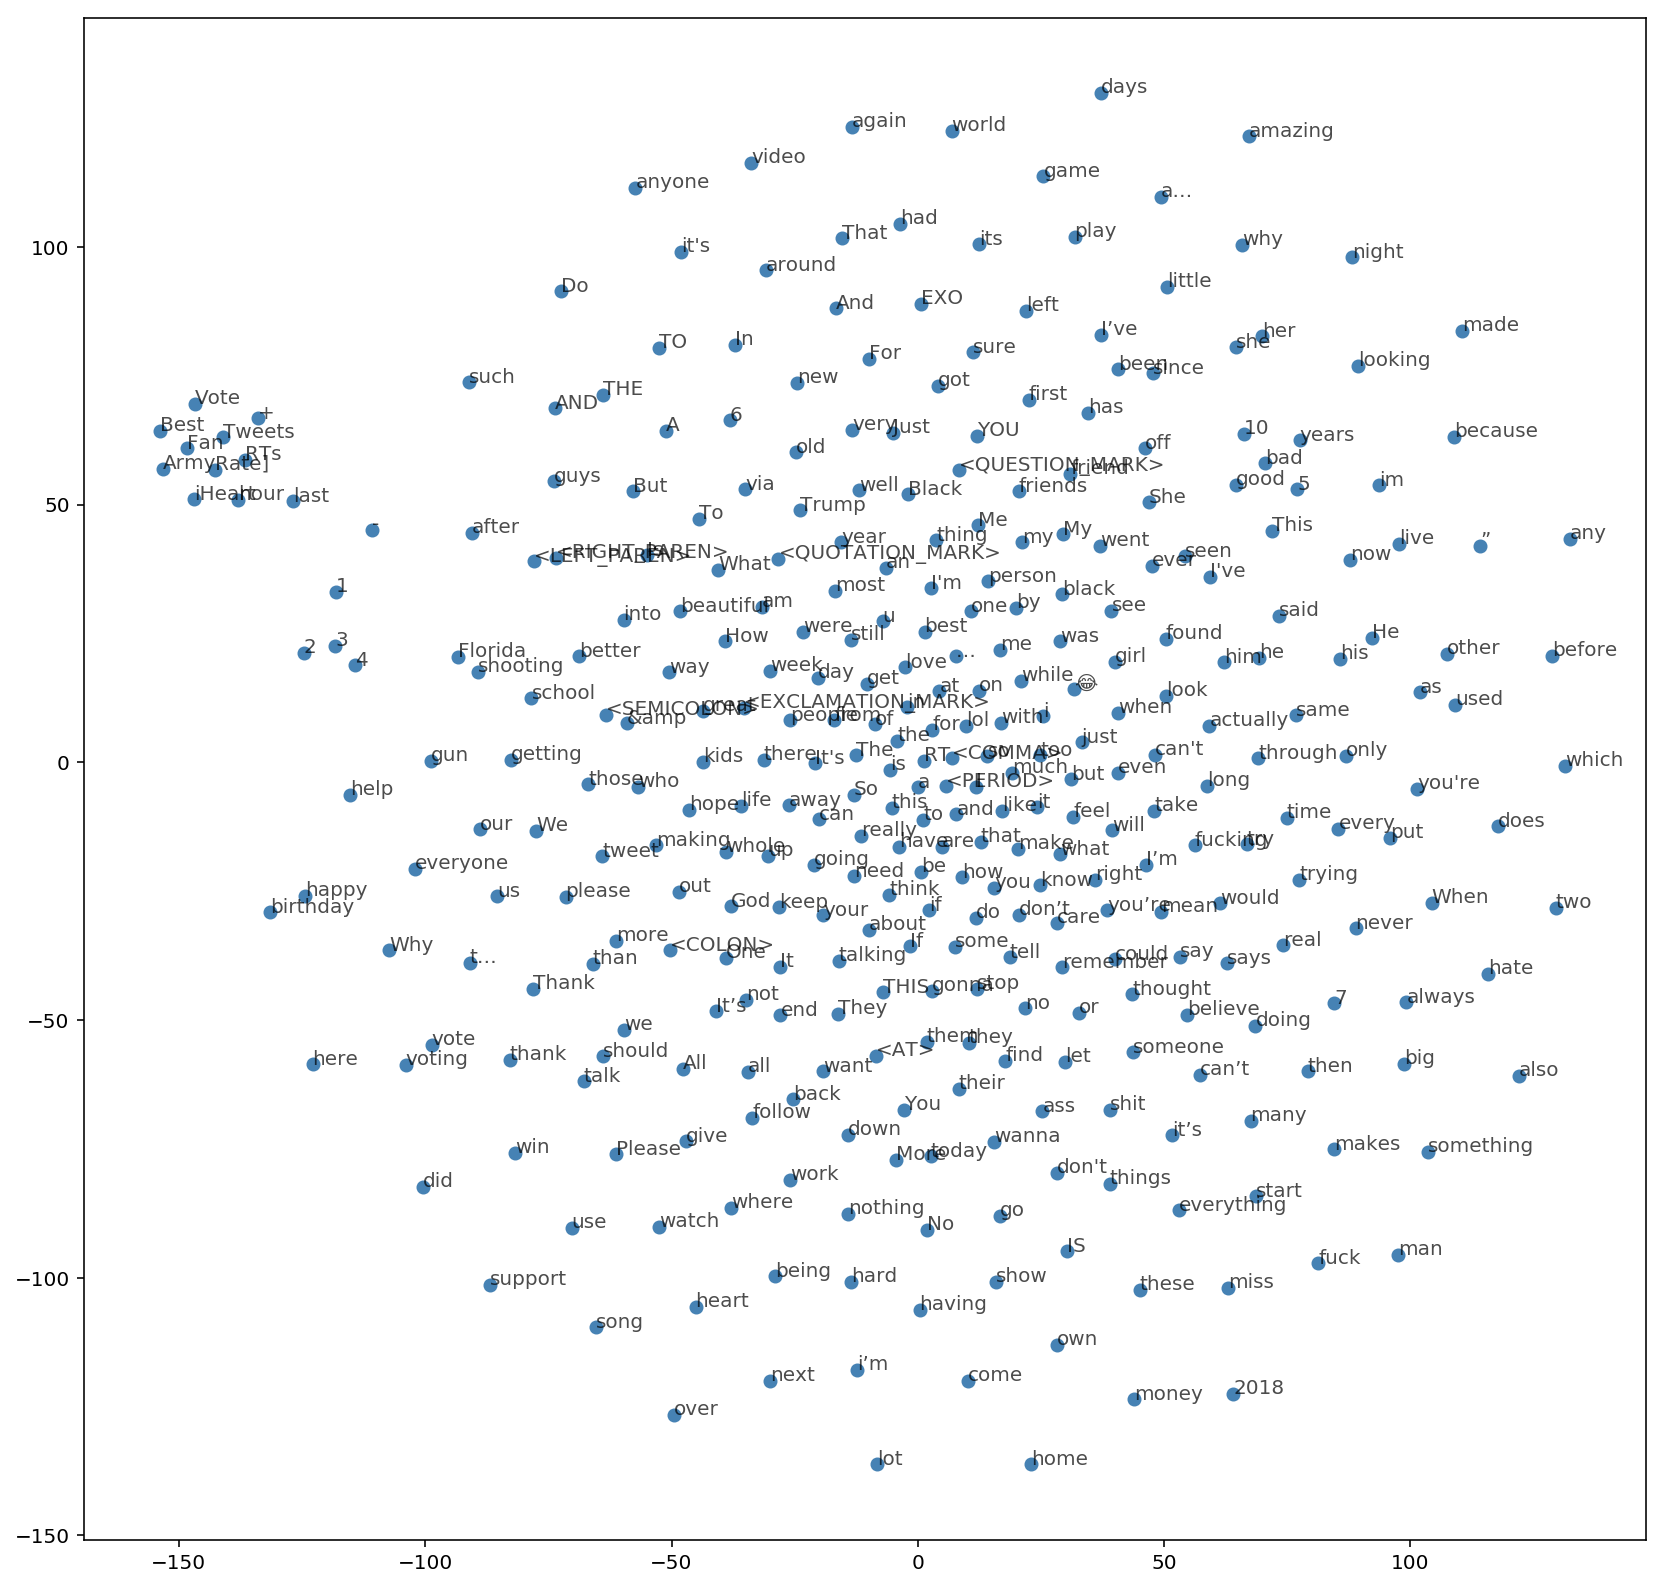

In [35]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

## Write out embeddings

In [36]:
embed_mat.shape

(68805, 200)

In [43]:
int_to_vocab[0]

'<COMMA>'

In [63]:
def write_embeddings(embed_mat, int_to_vocab, filename):
    embed_dim = embed_mat.shape[1]
    total_vocab = embed_mat.shape[0]
    fmt = '{} ' + '{:.6f} ' * embed_dim + '\n'
    with open('data/'+filename, mode='w') as f:
        for i in range(total_vocab):
            f.write(fmt.format(int_to_vocab[i], *embed_mat[i]))
    return

In [64]:
write_embeddings(embed_mat, int_to_vocab, 'twitter_embeddings.txt')